#  Supervised Classification Objective

**Objective:** Predict whether a supplier-related invoice will lead to a **dispute** or not.

- **Target variable:** `Dispute` (binary: Dispute occurred = 1, No dispute = 0)

## Step 1: Import Libraries

In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Step 2: Connect to SQL Server Data Warehouse

In [2]:
# SQL Server connection settings (using Windows Authentication)
server = 'localhost'  # e.g., 'localhost' or your server name
database = 'DW_Monoprix'  # Change to your target Data Warehouse
driver = '{ODBC Driver 17 for SQL Server}'

# Create connection string and connect
connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

## Step 3: Query Data from Table

In [3]:
query = """
SELECT
    F.Invoice_Amount,
    F.Invoice_VATRate,
    F.Product_Price,
    -- Delay in days
    DATEDIFF(day, InvDate.FullDate, InvDueDate.FullDate) AS Delay_Invoice,
    DATEDIFF(day, PsDate.FullDate, PayDueDate.FullDate) AS Delay_Payment,
    S.Country,
    S.City,
    P.Origin,
    C.BK_Category AS Category,
    -- Target: whether a dispute occurred
    CASE WHEN F.DisputeID IS NOT NULL THEN 1 ELSE 0 END AS HasDispute
FROM Fact_SupplierManagement F
LEFT JOIN DimSupplier S ON F.SupplierID = S.PK_Supplier
LEFT JOIN DimProduct P ON F.ProductID = P.PK_Product
LEFT JOIN DimCategory C ON F.CategoryID = C.PK_Category
LEFT JOIN DimDate InvDate ON F.InvoiceDateID = InvDate.PK_Date
LEFT JOIN DimDate InvDueDate ON F.InvoiceDueDateID = InvDueDate.PK_Date
LEFT JOIN DimDate PayDueDate ON F.InvoicePaymentDueDateID = PayDueDate.PK_Date
LEFT JOIN DimDate PsDate ON F.PsDateID = PsDate.PK_Date
"""

# Load the pre-joined data directly from SQL
df = pd.read_sql(query, conn)

# Replace NaN/NULL in numeric columns with 0
df[['Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment','Invoice_Amount']] = df[[
    'Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment','Invoice_Amount'
]].fillna(0)

# Replace NaN/NULL in categorical columns with 'UNSPECIFIED'
df[['Origin', 'Category']] = df[['Origin', 'Category']].fillna('UNSPECIFIED')
df[['Country', 'City']] = df[['Country', 'City']].fillna('UNKNOWN')


df


C:\Users\aneek\AppData\Local\Temp\ipykernel_40904\3459068129.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Invoice_Amount,Invoice_VATRate,Product_Price,Delay_Invoice,Delay_Payment,Country,City,Origin,Category,HasDispute
0,3212.0,5.5,54.30,15.0,0.0,France,Paris,FRANCE,Boisson,1
1,157.0,10.0,82.80,81.0,0.0,France,Paris,FRANCE,Boisson,1
2,1056.0,0.0,0.00,43.0,0.0,France,Paris,UNSPECIFIED,UNSPECIFIED,1
3,1971.0,20.0,48.71,35.0,-1041.0,France,Paris,FRANCE,Textile,1
4,521.0,0.0,0.00,21.0,0.0,France,Paris,UNSPECIFIED,UNSPECIFIED,1
...,...,...,...,...,...,...,...,...,...,...
10437,0.0,0.0,2.99,0.0,0.0,UNKNOWN,UNKNOWN,NAN,Bio et Ecologie,0
10438,0.0,0.0,2.50,0.0,0.0,UNKNOWN,UNKNOWN,NAN,Bio et Ecologie,0
10439,0.0,0.0,3.49,0.0,0.0,UNKNOWN,UNKNOWN,NAN,Bio et Ecologie,0
10440,0.0,0.0,8.00,0.0,0.0,UNKNOWN,UNKNOWN,NAN,Bio et Ecologie,0


## Step 4: Preprocess the Data

In [4]:
df_clean = df.dropna()
df_encoded = pd.get_dummies(df_clean, columns=['Country', 'City', 'Origin', 'Category'], drop_first=True)
df_encoded

,Invoice_Amount,Invoice_VATRate,Product_Price,Delay_Invoice,Delay_Payment,HasDispute,Country_France,Country_UNKNOWN,City_Angers,City_Anglet,...,Category_Pâtes,Category_Riz,Category_Sauces,Category_Sports,Category_Structures Sportives,Category_Textile,Category_Thé,Category_UNSPECIFIED,Category_Viande,Category_Épices
0,3212.0,5.5,54.30,15.0,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,157.0,10.0,82.80,81.0,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1056.0,0.0,0.00,43.0,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1971.0,20.0,48.71,35.0,-1041.0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,521.0,0.0,0.00,21.0,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10437,0.0,0.0,2.99,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10438,0.0,0.0,2.50,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10439,0.0,0.0,3.49,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10440,0.0,0.0,8.00,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Separate features and target
X = df_encoded.drop(columns=['HasDispute'])
y = df_encoded['HasDispute']

In [6]:
df_encoded['HasDispute'].value_counts()

1    7270
0    3172
Name: HasDispute, dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler

standadizer=StandardScaler()
data=standadizer.fit_transform(X)
data

array([[ 0.11039334, -0.33770925,  0.88980822, ..., -1.1115285 ,
        -0.04038187, -0.02188755],
       [-1.41444283,  0.2234578 ,  1.73710109, ..., -1.1115285 ,
        -0.04038187, -0.02188755],
       [-0.96572672, -1.0235801 , -0.72450768, ...,  0.89966204,
        -0.04038187, -0.02188755],
       ...,
       [-1.49280593, -1.0235801 , -0.62075147, ..., -1.1115285 ,
        -0.04038187, -0.02188755],
       [-1.49280593, -1.0235801 , -0.48667109, ..., -1.1115285 ,
        -0.04038187, -0.02188755],
       [-1.49280593, -1.0235801 , -0.66534583, ..., -1.1115285 ,
        -0.04038187, -0.02188755]])

In [8]:
from collections import Counter
Counter(X)

Counter({'Invoice_Amount': 1,
         'Invoice_VATRate': 1,
         'Product_Price': 1,
         'Delay_Invoice': 1,
         'Delay_Payment': 1,
         'Country_France': 1,
         'Country_UNKNOWN': 1,
         'City_Angers': 1,
         'City_Anglet': 1,
         'City_Annecy': 1,
         'City_Anneyron': 1,
         'City_Arinthod': 1,
         'City_Avignon': 1,
         'City_Beaune': 1,
         'City_Bordeaux': 1,
         'City_Boulogne-sur-Mer': 1,
         'City_Bourg-en-Bresse': 1,
         'City_Brest': 1,
         'City_Cahors': 1,
         'City_Calvados': 1,
         'City_Carcassonne': 1,
         'City_Castres': 1,
         'City_Châteaulin': 1,
         'City_Clermont-Ferrand': 1,
         'City_Courbevoie': 1,
         'City_Damville': 1,
         'City_Dijon': 1,
         'City_Evian': 1,
         'City_Gennevilliers': 1,
         'City_Grasse': 1,
         'City_Grenoble': 1,
         'City_Gémenos': 1,
         'City_La Gacilly': 1,
         'City_La Rochel

In [9]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

#shape of our data
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (8353, 110) (8353,)
Test set: (2089, 110) (2089,)


## Step 5: Train and Evaluate KNN

In [10]:
# Applying the KNN algorithm une fois l'affiche bleu apparait c que le training is well done
from sklearn.neighbors  import KNeighborsClassifier
k = 4
knn_clf = KNeighborsClassifier(n_neighbors = k)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

## Step 6: Train and Evaluate SVM

In [11]:
# Import necessary libraries for SVM
from sklearn.svm import SVC

# Initialize the SVM model (you can choose different kernels like 'linear', 'rbf', etc.)
svm_model = SVC(kernel='rbf')  # rbf kernel is commonly used

# Train the SVM model
svm_model.fit(X_train, y_train)

SVC()

## Step 7: Train and Evaluate XGBoost

In [12]:
# Import necessary libraries for XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


C:\Users\aneek\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9971278123504069

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       631
           1       1.00      1.00      1.00      1458

    accuracy                           1.00      2089
   macro avg       1.00      1.00      1.00      2089
weighted avg       1.00      1.00      1.00      2089


Confusion Matrix:
 [[ 629    2]
 [   4 1454]]


## Step 8: Summary Comparison


Model Accuracy Comparison:

       Model  Accuracy
0        KNN  0.934897
1  SVM (RBF)  0.768789
2    XGBoost  0.997128


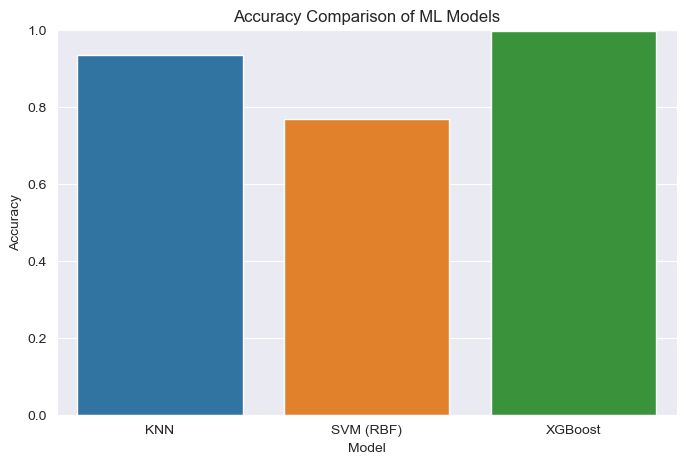

In [13]:
# Compare all models on accuracy
from sklearn.metrics import accuracy_score

# Predict with KNN and SVM
y_pred_knn = knn_clf.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Calculate accuracy
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

# Display results
summary_df = pd.DataFrame({
    'Model': ['KNN', 'SVM (RBF)', 'XGBoost'],
    'Accuracy': [acc_knn, acc_svm, acc_xgb]
})

print("\nModel Accuracy Comparison:\n")
print(summary_df)

# Optional: Plot comparison
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=summary_df)
plt.title('Accuracy Comparison of ML Models')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.show()


## ✅ Save the trained SVM model to a file using joblib

In [16]:
# Save the trained SVM model to a file using joblib
import joblib

# Save the model and the scaler
joblib.dump(svm_model, 'sco_purchasing_director_model.pkl')
joblib.dump(standadizer, 'sco_purchasing_director_scaler.pkl')


['sco_purchasing_director_scaler.pkl']

## Use This Code in Power BI (Python Script Visual)

In [ ]:
import pandas as pd
import joblib

# Load the saved model and scaler
svm_model = joblib.load('C:/Path/To/Your/sco_purchasing_director_model.pkl')
scaler = joblib.load('C:/Path/To/Your/sco_purchasing_director_scaler.pkl')

# Power BI automatically injects your dataset into a dataframe called 'dataset'
# Preprocess your dataset like in the notebook
dataset[['Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment','Invoice_Amount']] = dataset[[
    'Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment','Invoice_Amount'
]].fillna(0)

dataset[['Origin', 'Category']] = dataset[['Origin', 'Category']].fillna('UNSPECIFIED')
dataset[['Country', 'City']] = dataset[['Country', 'City']].fillna('UNKNOWN')

# Encode categorical variables to match training data
dataset_encoded = pd.get_dummies(dataset, columns=['Country', 'City', 'Origin', 'Category'], drop_first=True)

# Align columns with training set (important if not all categories appear in Power BI input)
model_columns = svm_model.feature_names_in_  # This requires sklearn >= 1.0
missing_cols = set(model_columns) - set(dataset_encoded.columns)
for col in missing_cols:
    dataset_encoded[col] = 0
dataset_encoded = dataset_encoded[model_columns]

# Scale features
X_scaled = scaler.transform(dataset_encoded)

# Predict
dataset['Predicted_Dispute'] = svm_model.predict(X_scaled)

# Output to Power BI
result = dataset[['Invoice_Amount', 'Predicted_Dispute']]  # or whatever columns you want to visualize
